In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [7]:

import plotly.express as px

ModuleNotFoundError: No module named 'plotly'

In [16]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [5]:
# аналогичным образом загружаем данные о пассажирах
passengers = pd.read_csv('data/passengers.csv')
# неподходящий формат данных приводим к тому, с которым Pandas может работать
passengers['Month'] = pd.to_datetime(passengers['Month'])
# также устанавливаем индекс и сортируем
df = passengers.set_index('Month').sort_index()

In [6]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


## Предсказание временного ряда с помощью деревьев

Попробуем обычное дерево решений и случайный лес, а потом сравним результаты

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [8]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [9]:
len(list_for_forecast)

143

In [10]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [11]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [12]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  46.714398202138


In [19]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 55.544286433341874
MAPE: 0.10965643959584417
MAE: 46.714398202138
R2:  0.4976465622767182


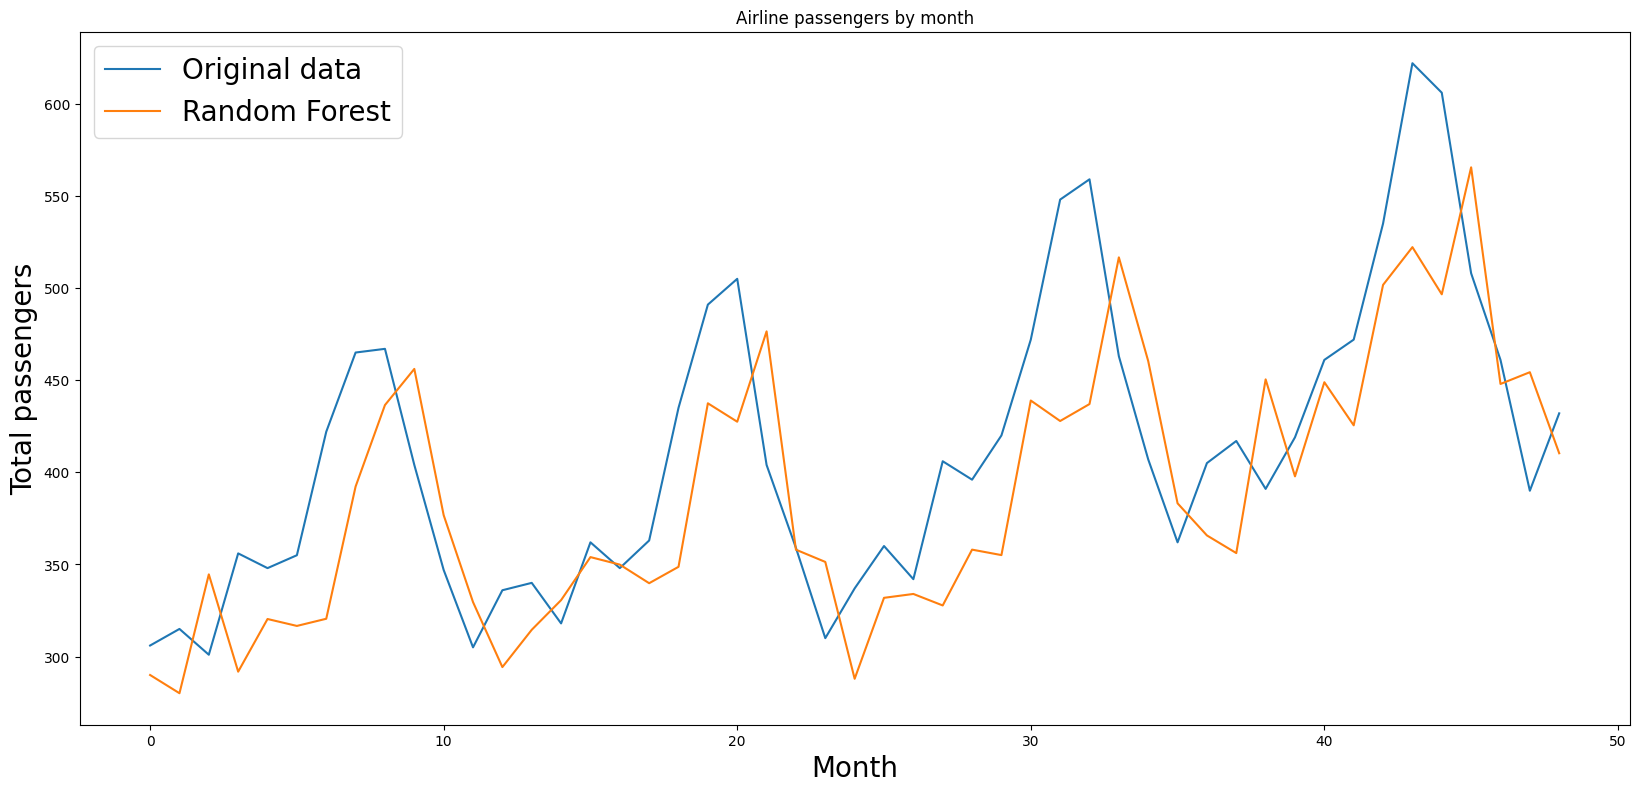

In [20]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Airline passengers by month')
plt.ylabel('Total passengers', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

In [22]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])


In [23]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 65.29403666867132
MAPE: 0.12270617535711836
MAE: 52.1530612244898
R2:  0.3058111520951716


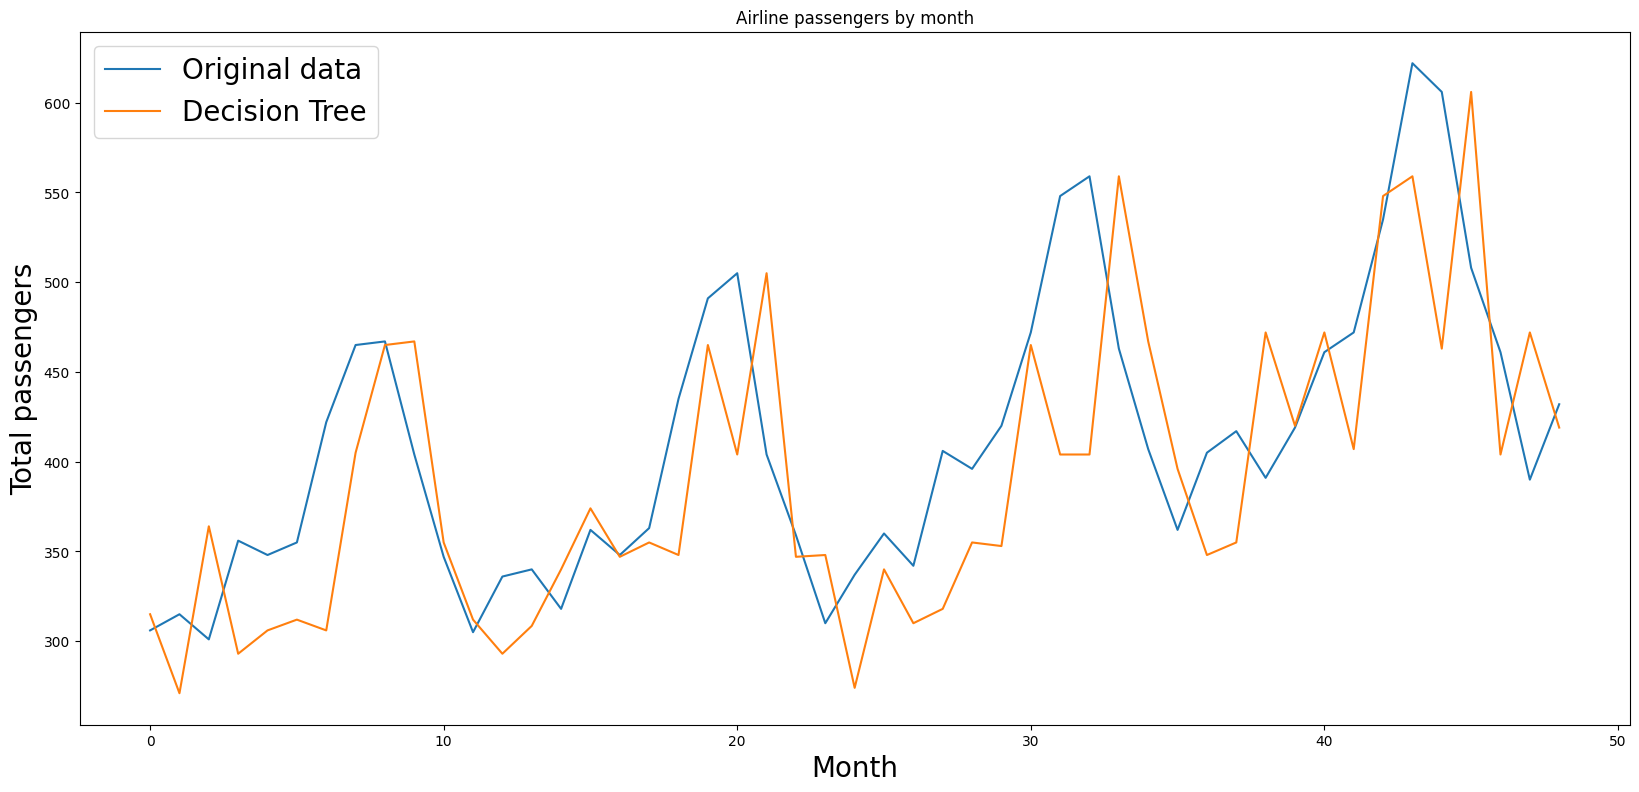

In [24]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Airline passengers by month')
plt.ylabel('Total passengers', fontsize="20")
plt.xlabel('Month', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [25]:
from sklearn.ensemble import IsolationForest

In [26]:
# аналогичным образом загружаем данные о пассажирах
pas = pd.read_csv('data/passengers.csv')
# неподходящий формат данных приводим к тому, с которым Pandas может работать
pas['Month'] = pd.to_datetime(passengers['Month'])
# также устанавливаем индекс и сортируем
pas

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [27]:
model = IsolationForest(contamination=0.004)
model.fit(pas[['Passengers']])

C:\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.004)

In [28]:
pas['outliers'] = pd.Series(model.predict(pas[['Passengers']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [29]:
pas.query('outliers=="yes"')

,Month,Passengers,outliers
138,1960-07-01,622,yes


ModuleNotFoundError: No module named 'plotly'

In [84]:
fig = px.scatter(pas.reset_index(), x='Month', y='Passengers', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()